# Task 1: Modern Control Synthesis


Create a Weight matrix for disturbance rejection

In [ ]:
P_s =

# Testing

Transfer function of the linearized pendulum:

        1
------------------
s^2 + 0.1 s - 9.81



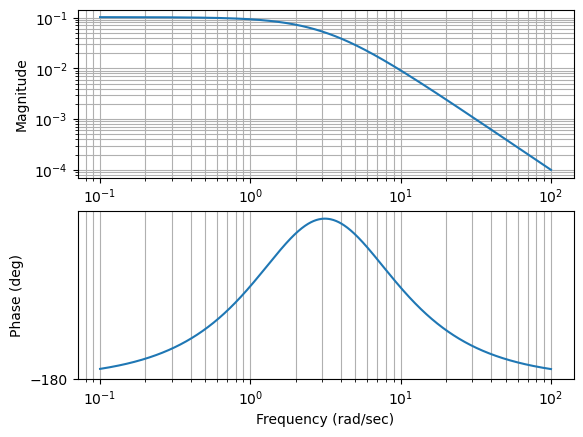

In [54]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Define the system dynamics
def inverted_pendulum_update(t, x, u, params={}):
    g = 9.81  # Acceleration due to gravity in m/s^2
    L = 1.0   # Length of the pendulum in meters
    b = 0.1   # Damping coefficient

    theta, theta_dot = x  # Unpack the state variables
    theta += np.pi        # Shift the angle to make the upright position the zero point
    u = u[0]              # Control input (torque)

    # Equation of motion
    theta_ddot = (u - b * theta_dot - g * np.sin(theta)) / L

    return np.array([theta_dot, theta_ddot])

def inverted_pendulum_output(t, x, u, params={}):
    return x[0]  # Output is the angle theta

# Create a NonlinearIOSystem for the pendulum
pendulum_nl = ct.NonlinearIOSystem(
    inverted_pendulum_update,  # Update function
    inverted_pendulum_output,  # Output function
    inputs=('u'),                       # Number of inputs
    outputs=('theta'),                  # Number of outputs
    states=('theta', 'theta_dot'),      # Number of states
    name='pendulum'
)

# Linearize the system around the upright position (theta = 0, theta_dot = 0) with zero input
x0 = [0, 0]  # Operating point (state)
u0 = [0]     # Operating point (input)
t0 = 0       # Time to linearize (usually 0 for time-invariant systems)

# Linearize the nonlinear system at the specified operating point
sys_lin = ct.linearize(pendulum_nl, xeq=x0, ueq=u0, t=t0)

# Convert the linearized state-space model to a transfer function
pendulum_tf = ct.ss2tf(sys_lin)
print("Transfer function of the linearized pendulum:")
print(pendulum_tf)

P_s = pendulum_tf

# Plot the singular value plot for the linearized system
plt.figure()
ct.bode_plot(pendulum_tf)
plt.show()

In [55]:
# Assume P_s is the transfer function you obtained earlier
poles = ct.pole(pendulum_tf)

# Check if all poles have negative real parts
is_stable = all(p.real < 0 for p in poles)

print("System is stable:" if is_stable else "System is unstable:")
print(poles)

System is unstable:
[-3.18249102+0.j  3.08249102+0.j]


In [56]:
sys_lin

<LinearIOSystem:sys[31]:['u[0]']->['y[0]']>

In [57]:
A = sys_lin.A

D, V = np.linalg.eig(A)
D

array([ 3.08249102, -3.18249102])

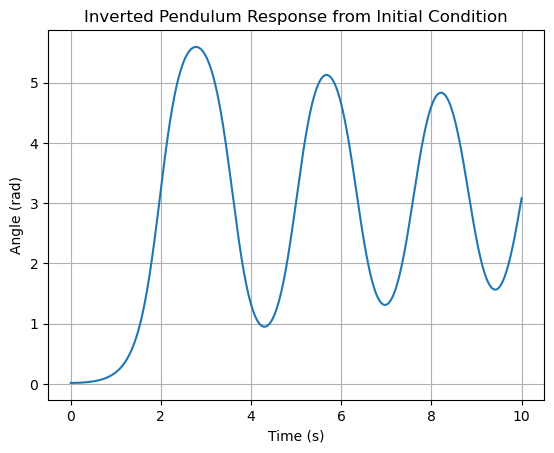

In [59]:
# Initial conditions: small angle (e.g., 5 degrees converted to radians)
theta_initial = np.deg2rad(1)  # Initial angle 
theta_dot_initial = 0          # Initial angular velocity
x0 = [theta_initial, theta_dot_initial]

# Time vector for the simulation
t = np.linspace(0, 10, 1000)  # Simulate for 10 seconds

# Zero input (no control input)
u = np.zeros_like(t)

# Simulate the response
t, y = ct.input_output_response(pendulum_nl, T=t, U=u, X0=x0)

# Plotting the response
plt.figure()
plt.plot(t, y)
plt.title('Inverted Pendulum Response from Initial Condition')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.grid(True)
plt.show()

In [60]:
theta_initial

0.017453292519943295

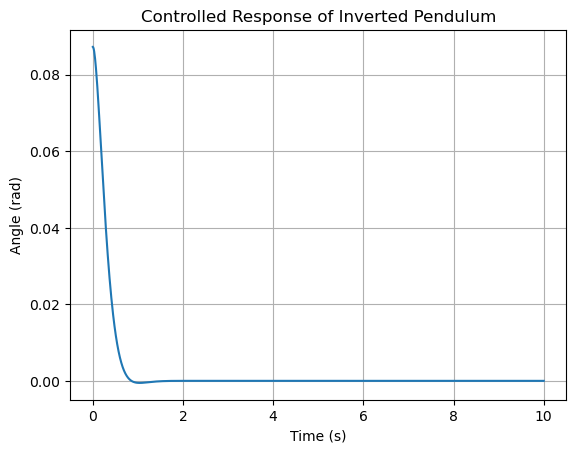

In [151]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Assume sys_lin is the linearized state-space model from previous steps
# Linearizing again for clarity in this context
# Define operating points and system parameters as before

# Define weight matrices for LQR
Q = np.diag([100, 1])  # State weight matrix
R = [0.1]              # Input weight matrix

# Compute the LQR controller gain
K, _, _ = ct.lqr(sys_lin.A, sys_lin.B, Q, R)

# Create the closed-loop system (A-BK)
A_cl = sys_lin.A - sys_lin.B @ K
B_cl = sys_lin.B
C_cl = sys_lin.C
D_cl = sys_lin.D

sys_cl = ct.StateSpace(A_cl, B_cl, C_cl, D_cl)

# Initial conditions and simulation parameters
theta_initial = 5 * np.pi / 180  # 5 degrees in radians
theta_dot_initial = 0
x0_cl = [theta_initial, theta_dot_initial]

# Simulate the response
t = np.linspace(0, 10, 1000)
t, y_cl = ct.initial_response(sys_cl, T=t, X0=x0_cl)

# Plotting the controlled response
plt.figure()
plt.plot(t, y_cl)
plt.title('Controlled Response of Inverted Pendulum')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.grid(True)
plt.show()


In [63]:
T_s = ct.ss2tf(sys_cl)
print(T_s)


         1
--------------------
s^2 + 9.79 s + 33.11



In [64]:
# Assume P_s is the transfer function you obtained earlier
poles = ct.pole(T_s)

# Check if all poles have negative real parts
is_stable = all(p.real < 0 for p in poles)

print("System is stable:" if is_stable else "System is unstable:")
print(poles)

System is stable:
[-4.8951229+3.02443849j -4.8951229-3.02443849j]


# LGR LQR

In [155]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt

# System matrices (assuming you have already a linearized model sys_lin)
A = sys_lin.A
B = sys_lin.B
C = sys_lin.C
D = sys_lin.D

Q = np.diag([100, 1])  # State weight matrix
R = [0.1]              # Input weight matrix

# Design state feedback controller (LQR)
K, S, E = ct.lqr(sys_lin, Q, R)

# Define LQE noise covariances
Qe = np.diag([0.1, 0.1])  # Process noise covariance
Re = np.diag([0.1])  # Measurement noise covariance

# Design observer (LQE)
L, P, E = ct.lqe(sys=sys_lin, QN=Qe, RN=Re)  

# Implement the observer
A_obs = A - L @ C
B_obs = np.hstack([B, L])
C_obs = np.eye(A.shape[0])  # Identity matrix for full state output
D_obs = np.zeros((A.shape[0], B_obs.shape[1]))

observer_ss = ct.StateSpace(A_obs, B_obs, C_obs, D_obs)

# Closed-loop system matrices
A_cl = A - B @ K
B_cl = B.copy()  # For input or external disturbance
C_cl = C.copy()
D_cl = D.copy()

# Combine into one system (assuming direct state measurement for simplicity)
sys_cl = ct.StateSpace(A_cl, B_cl, C_cl, D_cl)

# Simulate the system
t = np.linspace(0, 10, 1000)
x0 = np.array([0.1, 0, 0, 0])  # Initial condition for the states
t, y = ct.initial_response(sys_cl, T=t, X0=x0)

# Plotting the response
plt.figure()
plt.plot(t, y)
plt.title('Response of the Inverted Pendulum with LQR and Luenberger Observer')
plt.xlabel('Time (s)')
plt.ylabel('State response')
plt.grid(True)
plt.show()


IndexError: tuple index out of range

# PI Controller

PID Controller Transfer Function:

10 s^2 + 50 s + 5
-----------------
        s

Plant Transfer Function:

        1
------------------
s^2 + 0.1 s - 9.81

Open-loop Transfer Function:

  10 s^2 + 50 s + 5
----------------------
s^3 + 0.1 s^2 - 9.81 s

Closed-loop Transfer Function:

     10 s^2 + 50 s + 5
----------------------------
s^3 + 10.1 s^2 + 40.19 s + 5



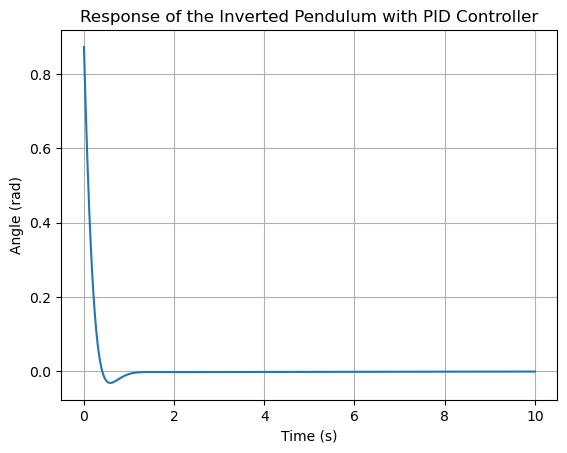

In [149]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Define the PID parameters
Kp = 50.0  # Proportional gain
Ki = 5.0   # Integral gain
Kd = 10  # Derivative gain

# Create the PID controller transfer function
num = [Kd, Kp, Ki]  # Coefficients of s^2, s, and constant
den = [1, 0]        # Coefficient for s in the denominator makes it proper
C_s = ct.TransferFunction(num, den)

print("PID Controller Transfer Function:")
print(C_s)

print("Plant Transfer Function:")
print(pendulum_tf)

# Assume sys_lin is your plant model obtained by linearizing the nonlinear system
# Combine the controller and the plant in a feedback loop
system_open_loop = C_s * pendulum_tf
print("Open-loop Transfer Function:")
print(system_open_loop)

system_closed_loop = ct.feedback(system_open_loop, 1)
print("Closed-loop Transfer Function:")
print(system_closed_loop)

# Simulate the response to an initial condition
t = np.linspace(0, 10, 1000)
initial_condition = [np.deg2rad(5), 0, 0]  # Starting with a small angle deviation, the third argument is the initial error
t, y = ct.initial_response(system_closed_loop, T=t, X0=initial_condition)

# Plotting the response
plt.figure()
plt.plot(t, y)
plt.title('Response of the Inverted Pendulum with PID Controller')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.grid(True)
plt.show()


In [145]:
print(system_closed_loop)


     10 s^2 + 50 s + 5
----------------------------
s^3 + 10.1 s^2 + 40.19 s + 5



In [146]:
# Assume P_s is the transfer function you obtained earlier
poles = ct.pole(system_closed_loop)

# Check if all poles have negative real parts
is_stable = all(p.real < 0 for p in poles)

print("System is stable:" if is_stable else "System is unstable:")
print(poles)

System is stable:
[-4.98574685+3.74845683j -4.98574685-3.74845683j -0.12850629+0.j        ]
